In [158]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

data1 = np.genfromtxt('dataSet1.csv',delimiter=',')
data2 = np.genfromtxt('dataSet2.csv',delimiter=',')
data3 = np.genfromtxt('dataSet3.csv',delimiter=',')
data4 = np.genfromtxt('dataSet4.csv',delimiter=',')

# Exploring Bayes Classifiers

![](q1.jpg)

# Comparing Bayes and Logistic Discriminant

In [159]:
class MyModels():
    def __init__(self, dataset):
        minmin = np.floor(min(min(dataset[:,1]),min(dataset[:,2]))).astype(int)
        maxmax = np.ceil(max(max(dataset[:,1]),max(dataset[:,2]))).astype(int)
        data_x_range = np.linspace(minmin,maxmax,100) 

        self.dataset = dataset
        self.xx, self.yy = np.meshgrid(data_x_range,data_x_range)
        self.data_grid = np.c_[self.xx.ravel(), self.yy.ravel()]
        self.data_c0 = dataset[dataset[:,0]==0, : ]
        self.data_c1 = dataset[dataset[:,0]==1, : ]

        self.svm_pred = None
        self.lda_pred = None
        self.pca_nb_pred = None
        self.bayes_pred = None
        self.logistic_pred = None


    def plot_decision_stat_surface(self, pred, title, levels=[0]):
        plt.pcolormesh(self.xx, self.yy, pred.reshape(self.xx.shape), cmap="jet")
        plt.contour(self.xx, self.yy, pred.reshape(self.xx.shape), levels=levels, colors="white", linewidths=[5])
        plt.scatter(self.data_c0[:,1],self.data_c0[:,2],label="class 0")
        plt.scatter(self.data_c1[:,1],self.data_c1[:,2],label="class 1")
        plt.title(title)
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.legend()
        plt.gca().set_aspect('equal')
        plt.show()


    def svm(self,plot=True):
        svm = SVC(kernel='linear').fit(self.dataset[:,1:3], self.dataset[:,0])
        svm_pred = svm.decision_function(self.data_grid)
        if plot:
            self.plot_decision_stat_surface(svm_pred,"SVM Decision Statistic Surface")
        self.svm_pred = svm_pred

    def lda(self,plot=True):
        lda = LinearDiscriminantAnalysis().fit(self.dataset[:,1:3], self.dataset[:,0])
        lda_pred = lda.decision_function(self.data_grid)
        if plot:
            self.plot_decision_stat_surface(lda_pred,"LDA Decision Statistic Surface")
        self.lda_pred = lda_pred

    def pca_nb(self,plot=True):
        pca = PCA(n_components=2)
        newx = pca.fit_transform(self.dataset[:,1:3])
        gnb = GaussianNB().fit(newx, self.dataset[:,0])

        # c0 = pca.transform(self.data_c0[:,1:3])
        # c1 = pca.transform(self.data_c1[:,1:3])
        # plt.scatter(c0[:,0], c0[:,1])
        # plt.scatter(c1[:,0], c1[:,1])
        # plt.title("PCA transformed Data")
        # plt.legend()
        # plt.show()

        pca_naiveBayes_pred = gnb.predict_proba(pca.transform(self.data_grid))
        pca_naiveBayes_loglikelihood_ratio = np.log(pca_naiveBayes_pred[:,1] / pca_naiveBayes_pred[:,0])
        if plot:
            self.plot_decision_stat_surface(pca_naiveBayes_loglikelihood_ratio,"PCA + Naive Bayes Decision Statistic Surface")
        self.pca_nb_pred = pca_naiveBayes_loglikelihood_ratio

    def bayes(self,plot=True):
        covMatrix0 = np.cov(self.data_c0[:,1:3].T)
        covMatrix1 = np.cov(self.data_c1[:,1:3].T)
        
        mu1 = np.mean(self.data_c1[:,1:3],axis=0)
        mu0 = np.mean(self.data_c0[:,1:3],axis=0)

        def gi(x, covmatrix, mu):
            a = np.diag(x.T@(-0.5*np.linalg.inv(covmatrix))@x)
            b = (np.linalg.inv(covmatrix)@mu).T@x
            c = -0.5*mu.T@np.linalg.inv(covmatrix)@mu
            d = -0.5*np.log(np.linalg.det(covmatrix))
            return  a + b + c + d
        
        g1 = gi(self.data_grid.T,covMatrix1,mu1)
        g0 = gi(self.data_grid.T,covMatrix0,mu0)

        bayes_decision_stat = g1-g0
        if plot:
            self.plot_decision_stat_surface(bayes_decision_stat,"Bayes Decision Statistic Surface")
        self.bayes_pred = bayes_decision_stat

    def logistic(self,plot=True):
        logistic = LogisticRegression().fit(self.dataset[:,1:3], self.dataset[:,0])
        logistic_pred = logistic.decision_function(self.data_grid)
        if plot:
            self.plot_decision_stat_surface(logistic_pred,"Logistic Decision Statistic Surface", levels=[0.5])
        self.logistic_pred = logistic_pred

    def all(self):
        self.svm(plot=False)
        self.lda(plot=False)
        self.pca_nb(plot=False)
        self.bayes(plot=False)
        self.logistic(plot=False)
        
        plt.contour(self.xx, self.yy, self.svm_pred.reshape(self.xx.shape), levels=[0], colors="blue", linewidths=[2])
        plt.contour(self.xx, self.yy, self.lda_pred.reshape(self.xx.shape), levels=[0], colors="green", linewidths=[2])
        plt.contour(self.xx, self.yy, self.pca_nb_pred.reshape(self.xx.shape), levels=[0], colors="red", linewidths=[2])
        plt.contour(self.xx, self.yy, self.bayes_pred.reshape(self.xx.shape), levels=[0], colors="purple", linewidths=[2])
        plt.contour(self.xx, self.yy, self.logistic_pred.reshape(self.xx.shape), levels=[0.5], colors="orange", linewidths=[2])

        plt.scatter(self.data_c0[:,1],self.data_c0[:,2],label="class 0")
        plt.scatter(self.data_c1[:,1],self.data_c1[:,2],label="class 1")

        contour_legend_elements = [
            Line2D([0], [0], color='blue', linewidth=2, label='SVM'),
            Line2D([0], [0], color='green', linewidth=2, label='LDA'),
            Line2D([0], [0], color='red', linewidth=2, label='PCA + Naive Bayes'),
            Line2D([0], [0], color='purple', linewidth=2, label='Bayes'),
            Line2D([0], [0], color='orange', linewidth=2, label='Logistic')

        ]
        scatter_legend_elements = [
            Line2D([0], [0], marker='o', color='blue', linestyle='', label='Class 0'),
            Line2D([0], [0], marker='o', color='orange', linestyle='', label='Class 1')
        ]
        legend_elements = contour_legend_elements + scatter_legend_elements

        plt.title("SVM vs LDA vs PCA+NB vs Bayes vs Logistic")
        plt.xlabel("x1")
        plt.ylabel("x2")
        plt.legend(handles=legend_elements)
        ax = plt.gca()
        ax.set_aspect('equal')   
        plt.show()

## 2)
### 2a/b)

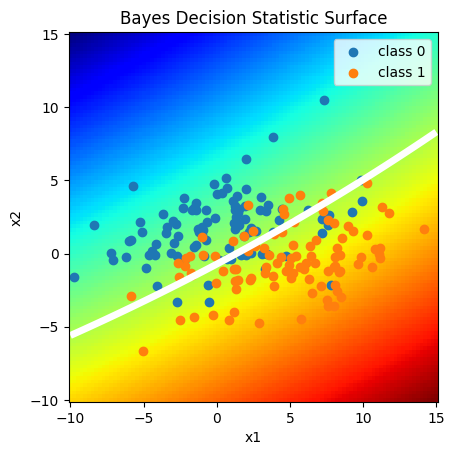

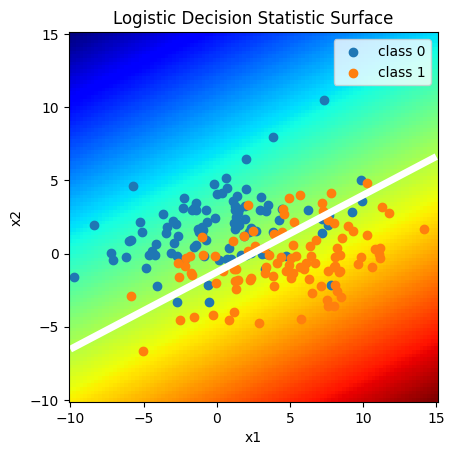

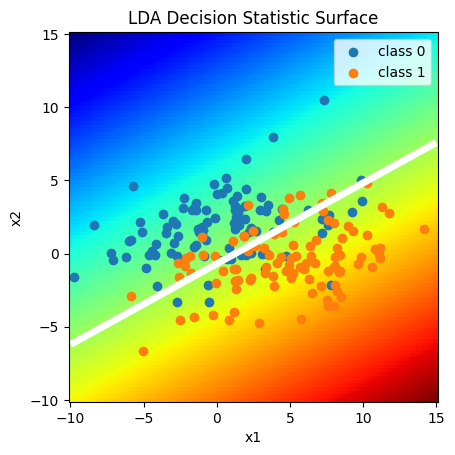

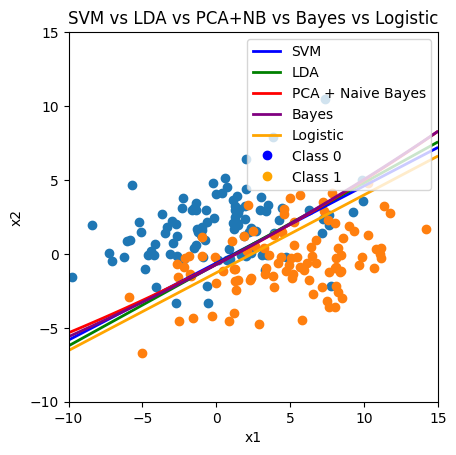

In [160]:
data1_models = MyModels(data1)
data1_models.bayes()
data1_models.logistic()
data1_models.lda()
data1_models.all()

### 2c)

All 5 classifiers resembled my sketch, which was basically a linear boundary.

The linear SVM classifier creates a decision boundary that's similar to mine because it searches for a linear vector that splits the two classes in a way that maximizes the amount of class 1 data on one side minimizes the distance of class 1 data on the wrong side. Since I created my boundary with a similar idea, these boundaries are similar.

The LDA classifier assumes that the two datasets are normal and have identical covariances and finds a linear boundary that maximizes the difference in the class means and in a direction where the inclass projections have the least amount of variance. These assumptions hold true so the boundary created by LDA is a linear boundary that optimally separates the data. Since I created my boundary with a similar idea, these boundaries are similar.

The PCA + Naive Bayes classifier assumes that the features are all independent. Since the data is normally distributed, this is true so the PCA+NB classifier creates a boundary that is similar to mine.

The Bayes classifier is similar to my sketch because the data was normal and had identical covariance matrices. This means that the Bayes classifier is essentially an LDA classifier, and as mentioned before, the LDA boundary resembles my sketch.

The logistic classifier assumes normal data which is a correct assumption. Thus, the boundary created by the logistic classifier is similar to my sketch.

## 3)
### 3a/b)

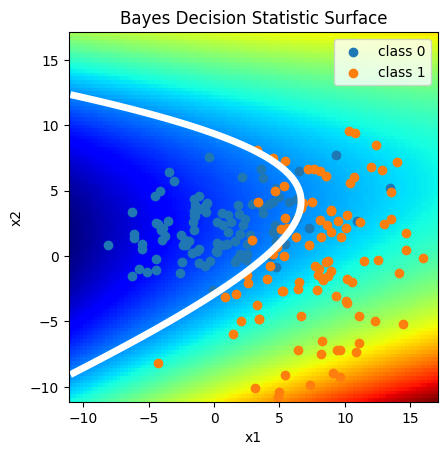

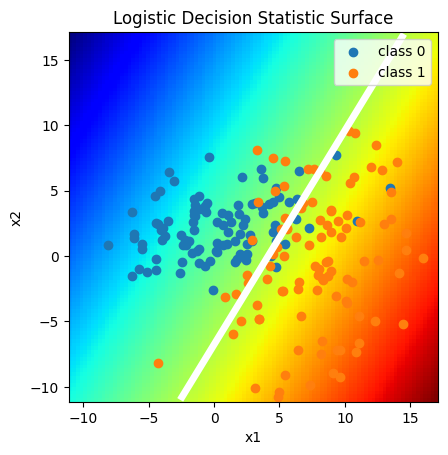

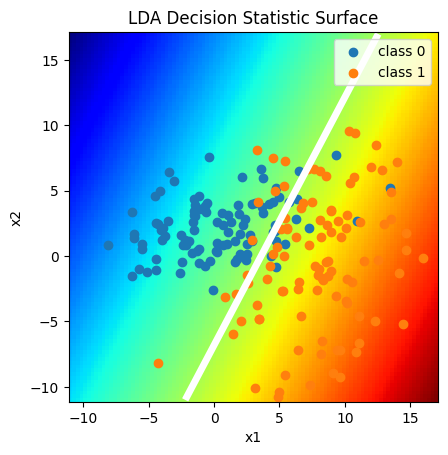

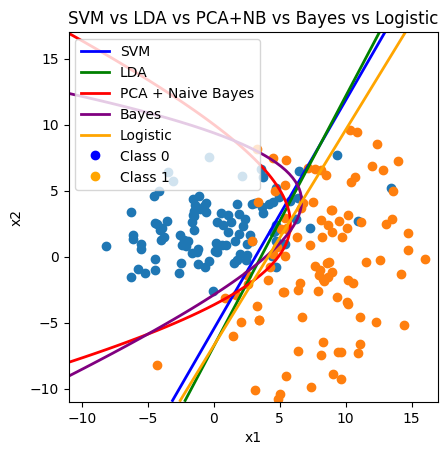

In [161]:
data2_models = MyModels(data2)
data2_models.bayes()
data2_models.logistic()
data2_models.lda()
data2_models.all()

In [162]:
cov0 = np.cov(data2_models.data_c0[:,1:3].T)
cov1 = np.cov(data2_models.data_c1[:,1:3].T)
mu0 = np.mean(data2_models.data_c0[:,1:3],axis=0)
mu1 = np.mean(data2_models.data_c1[:,1:3],axis=0)
print(mu0,cov0)
print(mu1, cov1)



[0.32413442 2.22889229] [[16.11610257  2.82044177]
 [ 2.82044177  4.61989413]]
[ 7.862393   -0.31757152] [[13.10860361  4.2227046 ]
 [ 4.2227046  25.06494421]]


### 3c)
All classifiers except the Bayesian ones resembled my sketch, which was basically a linear boundary.

The linear SVM classifier creates a decision boundary that's similar to mine because it searches for a linear vector that splits the two classes in a way that maximizes the amount of class 1 data on one side minimizes the distance of class 1 data on the wrong side. Since I created my boundary with a similar idea, these boundaries are similar.

The LDA classifier assumes that the two datasets are normal and have identical covariances but here the covariances are not identical. However, the difference in the means makes up for the different covariances, which means that the LDA is still able to find a decision boundary that separates the 2 classes appropriately. Thus, it is similar to my sketch

The PCA + Naive Bayes classifier does not produce a decision boundary similar to my sketch. The curve towards the left happens because the data has different covariances. Since the orange (class 1) data has has a higher covariance, the data is more spread than the blue (class 0) data. This results in the model being trained to believe that in spaces where there is no definitive orange/blue data, the model will assume that orange is more likely since it has a higher spread.   

Like the Naive Bayes classifier, the Bayes classifier doesn't produce a decision boundary similar to my sketch. The curve towards the left happens because the data has different covariances. Since the orange (class 1) data has has a higher covariance, the data is more spread than the blue (class 0) data. This results in the model being trained to believe that in spaces where there is no definitive orange/blue data, the model will assume that orange is more likely since it has a higher spread. The curve is tighter around the blue (class 0) data because the Bayes classifier accounts for the covariances of the class 1 and class 0 data. 

The logistic classifier assumes normal data which is a correct assumption. The boundary created by the logistic classifier is slightly closer to the orange (class 1) data because the logistic classifier is less influenced by more extreme data points. I think this results in a more optimal boundary compared to my sketch.

## 4)
### 4a/b)

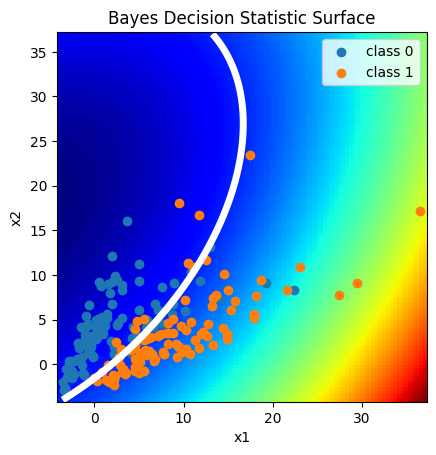

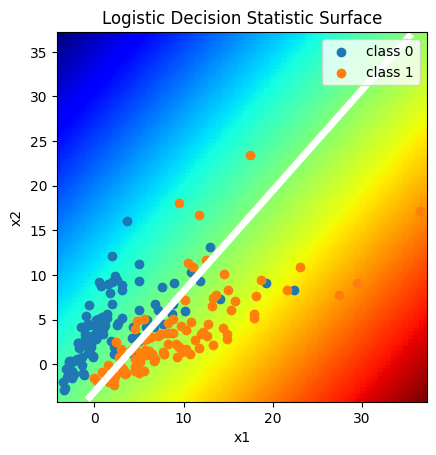

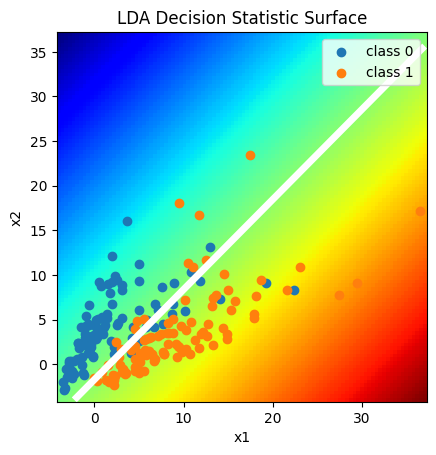

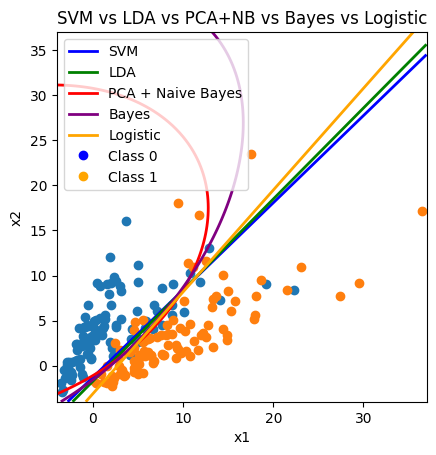

In [163]:
data3_models = MyModels(data3)
data3_models.bayes()
data3_models.logistic()
data3_models.lda()
data3_models.all()

### 4c)

All classifiers except the Bayesian ones resembled my sketch, which was basically a linear boundary.

The linear SVM classifier creates a decision boundary that's similar to mine because it searches for a linear vector that splits the two classes in a way that maximizes the amount of class 1 data on one side minimizes the distance of class 1 data on the wrong side. Since I created my boundary with a similar idea, these boundaries are similar.

The LDA classifier resembles my sketch. Although, the model assumes that the data is normally distributed with identical covariances, his assumption about the data is not true as this data is log normal. However, since direction of the covariances is similiar, the LDA classifier does a fine job, as it is able to identify a vector that when the data is projected onto it, there is a lot of discrimination between the two classes.

The PCA + Naive Bayes classifier does not look like my sketch. NB classifiers assume that data is normally distributed, but I think the curve to the left is caused by the orange (class 1) data having more spread especially for the data points that are not in the main clump. Since NB classifiers work by identifying the probability of a class given the data, the increased variance of orange data makes it so that the NB classifier will be more likely to choose class 1 when considering points near the SVM decision boundary line. 

Like the Naive Bayes classifier, the Bayes classifier doesn't produce a decision boundary similar to my sketch. I think the curve to the left is caused by the orange (class 1) data having more spread especially for the data points that are not in the main clump. Since Bayes classifiers work by identifying the probability of a class given the data, the increased variance of orange data makes it so that the Bayes classifier will be more likely to choose class 1 when considering points near the SVM decision boundary line. Compared to the NB classifer, the curve is more linear and I think this is due to the classifier taking into account of the different covariances. I think that the covariances of the data is likely greater than the standard deviations of the two PCA features, causing the decision boundary to be looser than the Naive Bayes classifier.

The logistic classifier assumes normal data which is an incorrect assumption. However, the boundary created by the logistic classifier is similar to my sketch because the difference in means is sufficient enough to separate the two classes.

## 5)
### 5a/b)

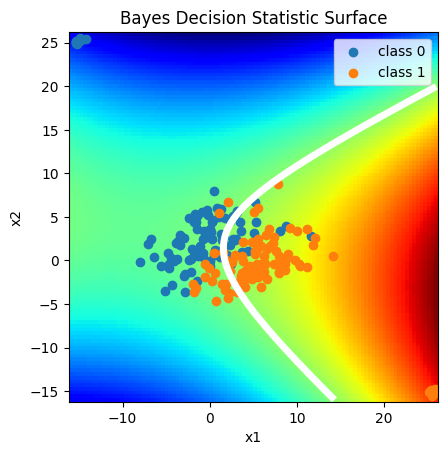

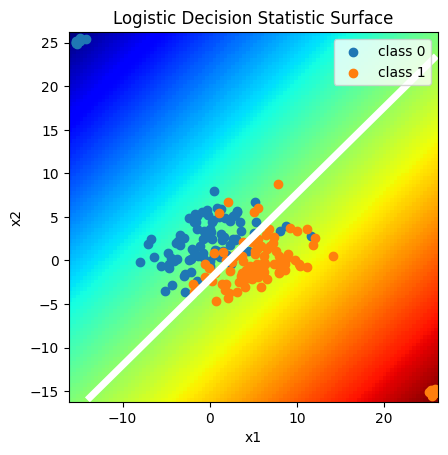

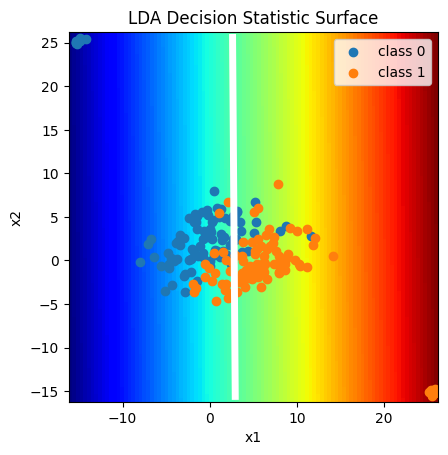

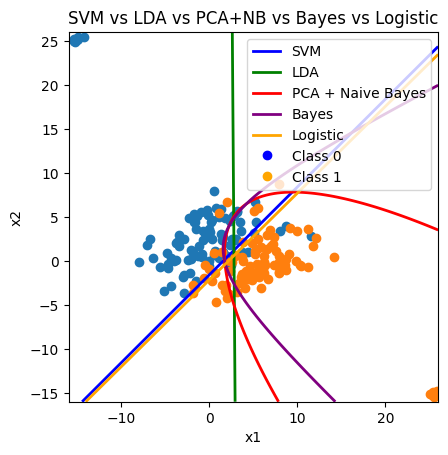

In [164]:
data4_models = MyModels(data4)
data4_models.bayes()
data4_models.logistic()
data4_models.lda()
data4_models.all()

### 5c)

All classifiers except the Bayesian ones and LDA resembled my sketch, which was basically a linear boundary.

The linear SVM classifier creates a decision boundary that's similar to mine because it searches for a linear vector that splits the two classes in a way that maximizes the amount of class 1 data on one side minimizes the distance of class 1 data on the wrong side. Since I created my boundary with a similar idea, these boundaries are similar.

The LDA classifier does not resemble my sketch because the model assumes that the data is normally distributed with identical covariances. This assumption about the data is not true as this data has outliers making it not really gaussian. Dispite the data being separable linearly separable, the LDA classifier fails. I think this is because the outliers change changes the direction of the covariance from one diagonal to the other diagonal. This causes the direction of the LDA vector to be wrong, resulting in a vertical line.

The PCA + NB classifier does not look like my sketch. The curve towards the right happens because the data has outliers. I think the outliers make it so that the conditional probability of class 1 given the data gets skewed, causing a curve towards one of the outlier clumps.

Like the Naive Bayes classifier, the Bayes classifier doesn't produce a decision boundary similar to my sketch. I think the curve to the left is caused by the orange (class 1) data having more spread especially for the data points that are not in the main clump. Since Bayes classifiers work by identifying the probability of a class given the data, the increased variance of orange data makes it so that the Bayes classifier will be more likely to choose class 1 when considering points near the SVM decision boundary line. Compared to the NB classifer, the curve less tight around the orange data and I think this is due to the classifier taking into account of the different covariances. I think that the covariances of the data is likely greater than the standard deviations of the two PCA features, causing the decision boundary to be looser than the Naive Bayes classifier.

The logistic classifier assumes normal data which is a sort of correct assumption. Although there are outliers, the logistic classifer doesn't get skewed by them because the decision statistic for outliers gets scaled down by the logit function. This results in the model being resiliant to the effect of the outliers, and creating a decision boundary similar to my sketch.

## 6)

From the results of the four datasets, we can deduce the following:

Linear SVM classifiers are pretty robust to most types of data, but this is highly reliant on the fact that the data is linearly separable. If any of the 4 datasets were distributed in a way that the optimal boundary isn't linear, this classifier will probably not be very effective.

LDA classifiers should only be used if there are no outliers and if the optimal boundary is linear. I think this is the biggest factor as seen by these four datasets. Although LDA assumes gaussian distributed data with identical covariance, with dataset 3, the data wasn't gaussian and LDA still worked. I think it's also important the the direction of the covariances of the two classes be in the direction of the boundary. As seen with dataset 4, when the covariance direction was nearly perpendicular to the SVM boundary, the LDA classifier did not perform well. 

PCA + NB classifier should be used only if the data is gaussian distributed. This classifier produced an inaccurate model only for datasets 3 and 4, which were the only ones that didn't have gaussian distributed data.

Bayes classifiers like PCA+NB classifiers also depend heavily on the data being normally distributed. As seen with dataset 4, the non-normal data cause the decision statistic surface to be hyperbolic, which is wildly off of what it should be.

Logistic classifiers depend on the data having an optimal boundary that's linear, and it's seen to perform best with outliers and data with a lot of spread. 